# Random Forest
## I. Importation des librairies

In [14]:
import csv
import numpy as np
from sklearn import preprocessing
from usefulCmdsAndFcns import get_metrics, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# 

## II. Lecture des descripteurs

In [15]:
# extraction des informations du csv
with open('../../inference/dataset.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
data = np.array(data)

label_names = data[:,1024]
unique_label = np.unique(label_names)
feature_values = data[:, :1024]

## III. Modèle Random Forest

In [16]:
# split données
X_train, X_test, y_train, y_test = train_test_split(feature_values, label_names, test_size=0.33, random_state=43)


# Random Forest
RandomForest_ml = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=100))
RandomForest_ml.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

## IV. Evaluation
Pour évaluer le modèle, on affichage la matrice de confusion et les différents scores.

Confusion matrix, without normalization
[[17  0  1  0  0  2  5  0  4  2]
 [ 0 21  3  0  0  4  0  0  1  1]
 [ 3  0  6  0  3  9  0  0  8  4]
 [ 0  0  1 14 11  0  8  5  2  9]
 [ 0  0  2  2 18  1  5  2  3  2]
 [ 0  6  0  1  2 18  1  0  1  2]
 [ 3  0  0  0  0  0 27  0  0  3]
 [ 0  0  0  2  3  1  0 21  0  0]
 [ 2  0  4  1  3  1  2  2 16  2]
 [ 2  0  4  2  1  0  6  1  2  9]]
Accuracy: 0.5061
Precision: 0.5187
Recall: 0.5061
F1 Score: 0.4951
Scores RandomForest:  0.47575757575757577


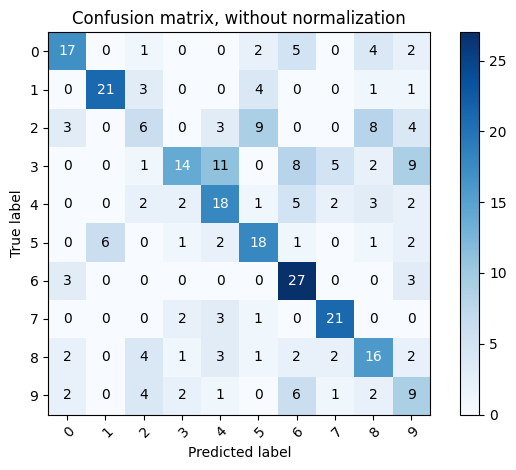

In [17]:
# evaluation du modele
plot_confusion_matrix(y_test,RandomForest_ml.predict(X_test))
get_metrics(y_test,RandomForest_ml.predict(X_test))
scores = cross_val_score(RandomForest_ml, X_test, y_test)
print("Scores RandomForest: ",scores.mean())
accuracy = RandomForest_ml.score(X_test, y_test)

Les performances sont correcte.

## V. Enregistrement

Enregistrement de la normalisation

In [18]:
with open('../../inference/RandomForest/modelRandomForest.csv', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(RandomForest_ml['standardscaler'].scale_)
    writer.writerow(RandomForest_ml['standardscaler'].mean_)

On utilise la même fonction que pour le modèle d'arbre de décision. En effet, la forêt est composée de plusieurs arbres. On doit donc juste traiter tous les arbres de la forêt pour obtenir le modèle.

In [19]:
def lecture_node(i):
    '''
    fonction permettant de parcourir l'arbre de décision de manière récursif et écrivant le code cpp permettant la décision
    prend en entrée le node i courant traité
    sort le texte correspondant au morceau de code de ses enfants
    '''
    if(clf.tree_.children_left[i] == clf.tree_.children_right[i]):
        # condition d'arret : le node est une feuille de l'arbre
        # "cout << \"" + unique_label[np.argmax(clf.tree_.value[i])] + "\" << endl;
        return "return " + str(np.argmax(clf.tree_.value[i])) + ";"
    else:
        # sinon on traite les enfants
        txt_1 = lecture_node(clf.tree_.children_left[i])
        txt_2 = lecture_node(clf.tree_.children_right[i])
        if(clf.tree_.feature[i] <512):
            feature = "mu["+str(clf.tree_.feature[i]) + "]"
        else:
            feature = "sigma[" + str(clf.tree_.feature[i]-512) + "]"
        Text_1 = "if("+ feature + " <= " + str(clf.tree_.threshold[i]) + "){" + txt_1 + "}"
        Text_2 = "else{" + txt_2 + "}"
        return Text_1 + Text_2

On peut écrire le code cpp et h en parcourant tous les arbres.

In [20]:
nb_arbre = 100

## génération du code cpp
txt = ""
txt += "#include <iostream>  \n"
txt += "#include \"codeRandomForest.h\" \n"
txt += "using namespace std; \n \n"

##fonction de decision arbre
for i in range(nb_arbre):
    txt += "int decision_tree_" + str(i) + "(double mu[], double sigma[]){\n"
    clf = RandomForest_ml['randomforestclassifier'].estimators_[i]
    txt += lecture_node(0)
    txt += "}\n"
txt += "\n"

##Fonction max
txt += "int maxTableau(double tableau[10]){\n"
txt += "double max = tableau[0];\n"
txt += "int index_max = 0;\n"
txt += "for(int i=0;i<10;i++){"
txt += "if(max<tableau[i]){"
txt += "index_max = i;"
txt +="max = tableau[i];"
txt += "}}return index_max;}\n"
txt +="\n"

##Fonction affichage resultat genre musical
txt += "void affichageResultat(int indexMaxGenres){\n"
txt += "switch(indexMaxGenres){"
for i in range(len(RandomForest_ml['randomforestclassifier'].classes_)):
    txt += "case " + str(i) +" :\n"
    txt += "cout << \"" + RandomForest_ml['randomforestclassifier'].classes_[i] + "\" << endl;break;\n"
txt += "}}\n \n"

##Fonction Forest
txt += "int randomForest(double mu[], double sigma[]){\n"
txt += "double genres[10] = {0};\n"
for i in range(nb_arbre):
    txt += "genres[decision_tree_" + str(i) + "(mu, sigma)]++;\n";

txt += "int indexMaxGenres = maxTableau(genres);\n"
txt += "affichageResultat(indexMaxGenres);"
txt += "return indexMaxGenres;\n"
txt += "}"

# écriture du code dans le fichier
fichier = open("../../inference/RandomForest/codeRandomForest.cpp", "w")
fichier.write(txt)
fichier.close()

## ecriture du h
txt = "#ifndef CODE_RANDOM_FOREST__H \n#define CODE_RANDOM_FOREST__H \n"
for i in range(nb_arbre):
    txt += "int decision_tree_" + str(i) + "(double mu[], double sigma[]);\n"
txt += "int maxTableau(double tableau[10]);\n"
txt += "void affichageResultat(int indexMaxGenres);\n"
txt += "int randomForest(double mu[], double sigma[]);\n"
txt += "#endif"
fichier = open("../../inference/RandomForest/codeRandomForest.h", "w")
fichier.write(txt)
fichier.close()


Codage des labels en indice

In [21]:
unique_label = np.unique(label_names)

# enc labelNames to indices
encName2Ind = preprocessing.LabelEncoder()
encName2Ind.fit(unique_label)
labelIndices_unique = encName2Ind.transform(unique_label)
labelIndices  = encName2Ind.transform(label_names)

# Conversion des noms des labels en indices
y_test = encName2Ind.transform(y_test)

Enregistrement de l'ensemble d'évaluation

In [22]:
txt = ""
txt += "#ifndef TEST_DATASET_H\n#define TEST_DATASET_H\n\n"
txt += "#define N_TEST_EXAMPLES " + str(X_test.shape[0]) + "\n"
txt += "#define N_FEATURES " + str(X_test.shape[1]) + "\n"
txt += "#define N_CLASSES 10\n\n"

txt += "float test_acc=" + str(accuracy) +";\n\n"

txt += "float X_test[N_TEST_EXAMPLES][N_FEATURES] = {\n"
for i in range(X_test.shape[0]-1):
    txt += "{"
    for j in range(X_test.shape[1]-1):
        txt += str(X_test[i,j]) +","
    txt += str(X_test[i,X_test.shape[1]-1]) + "},\n"
txt += "{"
for j in range(X_test.shape[1]-1):
    txt += str(X_test[X_test.shape[0]-1,j]) +","
txt += str(X_test[X_test.shape[0]-1,X_test.shape[1]-1]) + "}};\n\n"

txt += "int y_test[N_FEATURES]={"
for i in range(X_test.shape[0]-1):
    txt += str(y_test[i]) +","
txt += str(y_test[X_test.shape[0]-1]) +"};\n\n"

txt += "#endif"

# écriture du code dans le fichier
fichier = open("../../inference/RandomForest/test_dataset.h", "w")
fichier.write(txt)
fichier.close()